## Imports <a class="anchor" id="imports"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from tqdm.notebook import tqdm, trange
import pickle

In [2]:
data = pd.read_csv("WHO.csv")
_,n = data.shape
dic_cols = {x : y for (x,y) in zip(range(n), data.columns)}

### Number of missing values

Text(0, 0.5, 'Number of missing values')

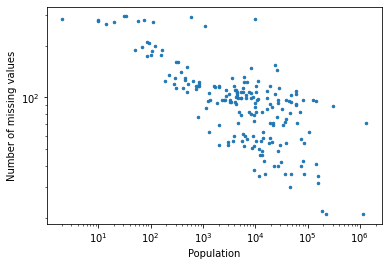

In [3]:
plt.plot(data.iloc[:,8:9], 358-data.count(axis=1), '.', markersize=5)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Population")
plt.ylabel("Number of missing values")
#plt.savefig("./figs/missing_data")

### Correlations and partial correlatiosn

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [5]:
def partial_corr_all(data) :
    """
    Computes the correlation of a DataFrame
    """
    n, m = data.shape
    part_corr = np.ones((m,m))

    for i in trange(m) :
        for j in trange(i, leave=False) :
            pred_col = np.r_[:j, j+1:i, i+1:m]
            targ_col = i
            X,y = data.iloc[:,pred_col], data.iloc[:,targ_col]
            est = make_pipeline(PolynomialFeatures(1), LinearRegression())
            est.fit(X, y)

            res_i = y - est.predict(X)

            targ_col = j
            X,y = data.iloc[:,pred_col], data.iloc[:,targ_col]
            est = make_pipeline(PolynomialFeatures(1), LinearRegression())
            est.fit(X, y)

            res_j = y - est.predict(X)

            c = np.corrcoef(res_i, res_j)[1,0]
            part_corr[i,j] = c
            part_corr[j,i] = c
    
    return part_corr

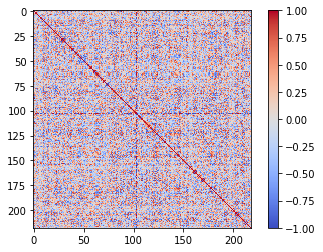

In [7]:
plt.imshow(part_corr, cmap="coolwarm")
plt.clim(-1,1)
plt.colorbar()
#plt.savefig("./figs/partial_corr_correct")

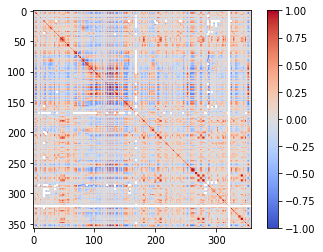

In [8]:
corr = data.corr()
plt.imshow(corr, cmap="coolwarm")
plt.clim(-1,1)
plt.colorbar()
#plt.savefig("./figs/corr_mat")

## Preprocessing data

In [9]:
def preprocess(nan_val="mean") :
    data = pd.read_csv("WHO.csv")
    to_remove = np.argwhere((data.count(axis=1) < 140).to_numpy()).ravel()
    data.drop(to_remove, inplace=True)
    to_remove2 = np.argwhere((data.count() < 135).to_numpy()).flatten()
    data.drop(data.columns[to_remove2], axis=1, inplace=True)
    if nan_val == "mean" :
        data.fillna(data.mean(), inplace=True)
    elif nan_val == "median" :
        data.fillna(data.median(), inplace=True)
    else :
        try :
            data.fillna(nan_val, inplace=True)
        except :
            print("NaN values left in the dataset.")

    dic = {y : x for (x,y) in data.iloc[:,:2].to_numpy()}
    return dic, data.iloc[:,3:]

In [10]:
dic, data = preprocess()

## Question 1 : Regression of fertility rate

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [12]:
#dic_cols

In [13]:
dic_cols[9]

'Population annual growth rate (%)'

In [14]:
r = np.argwhere(np.abs(part_corr[9]) > 0.8).flatten()
cols_r = [dic_cols[elem] for elem in r]

In [15]:
for elem in r :
    print(f'{dic_cols[elem]} : {part_corr[9,elem]:10f}, {dic_cols[elem] in data.columns}')

Population annual growth rate (%) :   1.000000, True
Population living below the poverty line (% living on &lt; US$1 per day) :   0.911414, False
Registration coverage of births (%) :   0.847328, True
External resources for health as percentage of total expenditure on health :  -0.820305, True
Age-standardized mortality rate for cardiovascular diseases (per 100 000 population) :  -0.801505, True


In [16]:
# delete since not in data
del cols_r[1]

In [17]:
data_X, data_Y = data[cols_r[1:]].to_numpy(), data[cols_r[0]].to_numpy()

In [18]:
seed = 32
split = 0.8
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=1-split, random_state=seed)

In [19]:
est = make_pipeline(PolynomialFeatures(1), LinearRegression())
est.fit(train_X, train_Y)
print(f"Training : {mse(est.predict(train_X),train_Y)}, Testing : {mse(est.predict(test_X),test_Y)}")

Training : 0.7115203715824945, Testing : 1.023326740094304


In [27]:
# Loss region
import warnings
warnings.filterwarnings("ignore") #Warnings due to lasso not converging

n_alp, n_l1 = 200,200
alpha = np.logspace(-10,10,n_alp)
l1_ratio = np.linspace(0,1, n_l1)
train_errs = np.zeros((n_alp,n_l1))
test_errs = np.zeros((n_alp,n_l1))

for i in trange(n_alp) :
    for j in range(n_l1) :
        est = make_pipeline(PolynomialFeatures(1), ElasticNet(alpha=alpha[i], l1_ratio=l1_ratio[j]))
        est.fit(train_X, train_Y)
        train_errs[i,j] = mse(est.predict(train_X),train_Y)
        test_errs[i,j] = mse(est.predict(test_X),test_Y)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0, 0.5, '$L^1$ ratio')

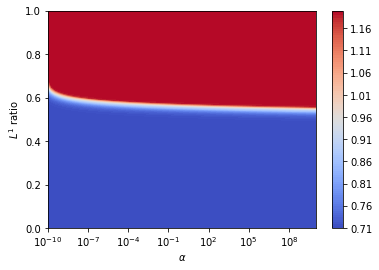

In [28]:
plt.contourf(alpha, l1_ratio, train_errs,100, cmap="coolwarm")
plt.colorbar()
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$L^1$ ratio")
#plt.savefig("./figs/loss_surf_train")

Text(0, 0.5, '$L^1$ ratio')

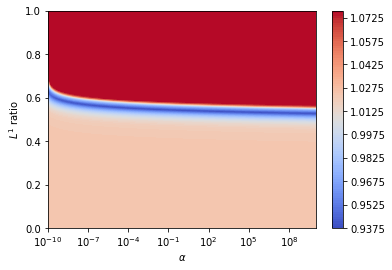

In [29]:
plt.contourf(alpha, l1_ratio, test_errs,100, cmap="coolwarm")
plt.colorbar()
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$L^1$ ratio")
#plt.savefig("./figs/loss_surf_test")

In [30]:
a,b = np.unravel_index(test_errs.argmin(), test_errs.shape)
print(f"Test : {test_errs[a,b]:.5f}, Train : {train_errs[a,b]:.5f}\nalpha : {alpha[b]:.5f}, l1 ratio : {l1_ratio[a]:.5f}")

Test : 0.93883, Train : 0.77268
alpha : 77525974.88629, l1 ratio : 0.52764


## Question 2 : Distribution mortality causes between men and women

In [31]:
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal

In [32]:
def hist(*args,**kwargs) :
    n_s = []
    bins_s = []
    bins = kwargs.get("bins", 50)
    alpha = kwargs.get("alpha", .7)
    for arg in args :
        n,bins,_ = plt.hist(arg, bins=bins, weights=np.ones(len(arg)) / len(arg), alpha=alpha)
        n_s.append(n)
        bins_s.append(bins)
    
    plt.title(kwargs.get("title", None))
    plt.legend(kwargs.get("legend",[]))
    plt.xlabel(kwargs.get("xlabel"), None)
    plt.ylabel(kwargs.get("ylabel"), None)
    return n_s, bins_s

def hist_and_mwu(data, cols, **kwargs) :
    selected_data = data[cols]
    hist(*selected_data.to_numpy().T, **kwargs)

    if len(cols) != 2 :
        print("Inconsistent number of values for MWU test.")
        return
    
    return mwu(data[cols[0]], data[cols[1]])

def kr_test(data, cols) :
    selected_data = data[cols]
    pval = kruskal(*selected_data.to_numpy())
    
    return pval

In [33]:
dic, data = preprocess(None)

NaN values left in the dataset.


In [34]:
#list(filter(lambda x: "deaths" in x, data.columns))

In [35]:
cols = ['Colon_and_Rectum_cancer_deaths_per_100_000_men',
 'Colon_and_Rectum_cancer_deaths_per_100_000_women',
 'Colon_and_Rectum_cancer_number_of_female_deaths',
 'Colon_and_Rectum_cancer_number_of_male_deaths',
 'Liver_cancer_deaths_per_100_000_men',
 'Liver_cancer_deaths_per_100_000_women',
 'Liver_cancer_number_of_female_deaths',
 'Liver_cancer_number_of_male_deaths',
 'Lung_cancer_deaths_per_100_000_men',
 'Lung_cancer_deaths_per_100_000_women',
 'Lung_cancer_number_of_female_deaths',
 'Lung_cancer_number_of_male_deaths',
 'Stomach_cancer_deaths_per_100_000_men',
 'Stomach_cancer_deaths_per_100_000_women',
 'Stomach_cancer_number_of_female_deaths',
 'Stomach_cancer_number_of_male_deaths']

In [36]:
data = data[cols].dropna()

#### M/F comparison

MannwhitneyuResult(statistic=10922.5, pvalue=9.272068290739968e-05)


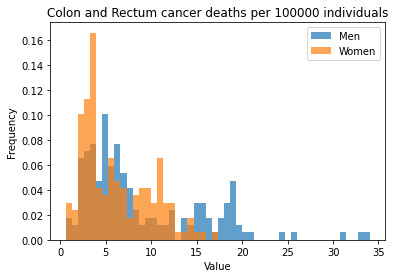

In [37]:
print(
    hist_and_mwu(data,['Colon_and_Rectum_cancer_deaths_per_100_000_men',
             'Colon_and_Rectum_cancer_deaths_per_100_000_women'],
            legend=["Men", "Women"],
            title="Colon and Rectum cancer deaths per 100000 individuals",
            ylabel="Frequency",
            xlabel="Value")
    )
#plt.savefig(f"./figs/CRC_100000")

MannwhitneyuResult(statistic=13956.0, pvalue=0.35915919049484535)


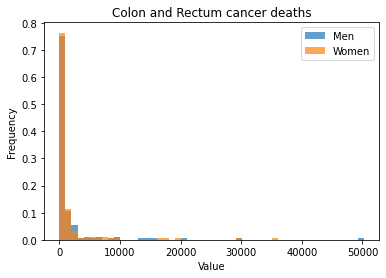

In [38]:
print(
    hist_and_mwu(data,['Colon_and_Rectum_cancer_number_of_male_deaths',
             'Colon_and_Rectum_cancer_number_of_female_deaths'],
            legend=["Men", "Women"],
            title="Colon and Rectum cancer deaths",
            ylabel="Frequency",
            xlabel="Value")
    )
#plt.savefig(f"./figs/CRC")

#### Across disease comparison

In [39]:
kr_test(data, ['Colon_and_Rectum_cancer_deaths_per_100_000_men',
 'Liver_cancer_deaths_per_100_000_men',
 'Lung_cancer_deaths_per_100_000_men',
 'Stomach_cancer_deaths_per_100_000_men',])

KruskalResult(statistic=201.59869576167202, pvalue=0.03927952646670891)

## Question 3 : Predicting cancer mortality rates
### Fitting a simple neural network

In [86]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [87]:
dic, data = preprocess()

In [88]:
data = (data - data.mean()) / data.std()

In [89]:
cancer_cols = list(filter(lambda x : "cancer" in x.lower(), data.columns))
cancer_preds_cols = list(filter(lambda x : "cancer" not in x.lower(), data.columns))
data_Y, data_X = data[cancer_cols].to_numpy(), data[cancer_preds_cols].to_numpy()

In [90]:
seed = 76
split = 0.8
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=1-split, random_state=seed)

train_X, train_Y = torch.Tensor(train_X).to(device), torch.Tensor(train_Y).to(device)
test_X, test_Y = torch.Tensor(test_X).to(device), torch.Tensor(test_Y).to(device)

In [91]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(174, 256)
        self.fc2 = nn.Linear(256, 45)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [92]:
def train(model,X,y, optimizer, loss_fn) :
    model.train()
    
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    return loss.item()

def test(model,X,y,loss_fn) :  
    model.eval()

    with torch.no_grad():
        pred = model(X)
    
    return loss_fn(pred, y).item()

In [93]:
model = NeuralNetwork().to(device)

In [94]:
# Training the network
loss_fn = nn.MSELoss()
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses,test_losses = [],[]

pbar = trange(epochs)
for epoch in pbar :
    trainloss = train(model,train_X, train_Y,optimizer,loss_fn)
    testloss = test(model,test_X, test_Y,loss_fn)
    
    train_losses.append(trainloss)
    test_losses.append(testloss)
    pbar.set_postfix({"loss" : trainloss, "test loss":testloss})

  0%|          | 0/1000 [00:00<?, ?it/s]

Min test losses : 0.27181118726730347


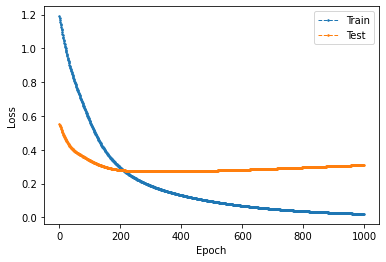

In [95]:
plt.plot(train_losses,".--",linewidth=1,markersize=3, label="Train")
plt.plot(test_losses,".--",linewidth=1,markersize=3, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
print(f"Min test losses : {min(test_losses)}")
#plt.savefig("./figs/ML_predict")

### PCA analysis

In [96]:
from sklearn.decomposition import PCA

In [97]:
pred_data = data[cancer_preds_cols]

In [98]:
pca = PCA().fit(pred_data)
eigValues = pca.explained_variance_ 
loadings = pca.components_
data_new = pca.fit_transform(pred_data)

(0.0, 50.0)

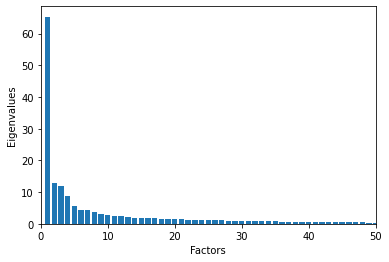

In [99]:
_,numPredictors = pred_data.shape
plt.bar(np.linspace(1,numPredictors,numPredictors),eigValues)
#plt.title('Scree plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.xlim(0,50)
#plt.savefig("./figs/scree")

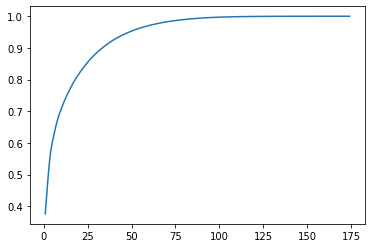

In [100]:
plt.plot(np.linspace(1,numPredictors,numPredictors), np.cumsum(pca.explained_variance_ratio_), label="Total explained variance")

### PCA directions

In [101]:
p = pd.DataFrame(loadings, index=pred_data.columns)

In [102]:
def significative_comps(eigvect, cutoff=0.3) :
    """
    @ eigvect : (pd.Series) eigenvector of the pca decomposition
    @ cutoff : minimum value for a component to be considered significative
    Returns the most significative components.
    """
    return eigvect[eigvect.abs()>cutoff]

In [103]:
significative_comps(p.iloc[:,0], 0.2) #feeling, introvert

Deaths among children under five years of age due to neonatal causes (%)   -0.269332
Name: 0, dtype: float64

### Double descent

In [108]:
cancer_cols = list(filter(lambda x : "cancer" in x.lower(), data.columns))
cancer_preds_cols = list(filter(lambda x : "cancer" not in x.lower(), data.columns))
data_Y, data_X = data[cancer_cols].to_numpy(), data[cancer_preds_cols].to_numpy()

In [141]:
# We average over reps for the minimum values found
# Can be long to run with 10 reps

min_test = []
reps = 2
loss_fn = nn.MSELoss()
epochs = 500

for k in trange(1,100) :
    m_val = 0
    
    for _ in range(reps) :
        seed = 76
        split = 0.8
        train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=1-split, random_state=seed)
        train_X, test_X = pca.transform(train_X)[:,:k], pca.transform(test_X)[:,:k]
        train_X, train_Y = torch.Tensor(train_X).to(device), torch.Tensor(train_Y).to(device)
        test_X, test_Y = torch.Tensor(test_X).to(device), torch.Tensor(test_Y).to(device)

        class NeuralNetwork(nn.Module):
            def __init__(self):
                super(NeuralNetwork, self).__init__()
                self.fc1 = nn.Linear(k, 256)
                self.fc2 = nn.Linear(256, 45)

            def forward(self, x):
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                return x

        model = NeuralNetwork().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        train_losses,test_losses = [],[]

        for epoch in range(epochs) :
            trainloss = train(model,train_X, train_Y,optimizer,loss_fn)
            testloss = test(model,test_X, test_Y,loss_fn)

            train_losses.append(trainloss)
            test_losses.append(testloss)
        
        m_val += min(test_losses)
    m_val /= reps
    min_test.append(m_val)

  0%|          | 0/99 [00:00<?, ?it/s]

Text(0, 0.5, 'Average minimum loss (2 reps)')

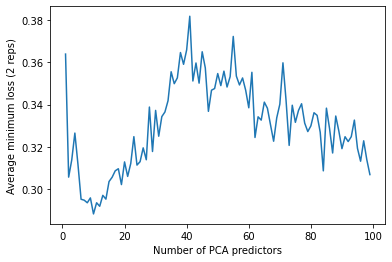

In [142]:
plt.plot(range(1,100),min_test)
plt.xlabel("Number of PCA predictors")
plt.ylabel(f"Average minimum loss ({reps} reps)")
#plt.savefig("./figs/double_descent")